# Introduction 
This is a notebook for developing model for the <a href="https://www.kaggle.com/competitions/spaceship-titanic/data?select=test.csv">Spaceship Titanic</a> competition.

In [1]:
!uv pip install hyperopt

Audited 1 package in 33ms


## Library Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from xgboost import XGBClassifier

import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline

import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

## EDA (Exploratory Data Analysis)

In [3]:
# read in the train and test datasets and inspect the data
train = pd.read_csv("data/train.csv")

In [4]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


/var/folders/cz/sb2kbc4925qcf91d0v0pj8ch0000gn/T/ipykernel_987/3592638239.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(["{:,.0f}".format(v) for v in vals])


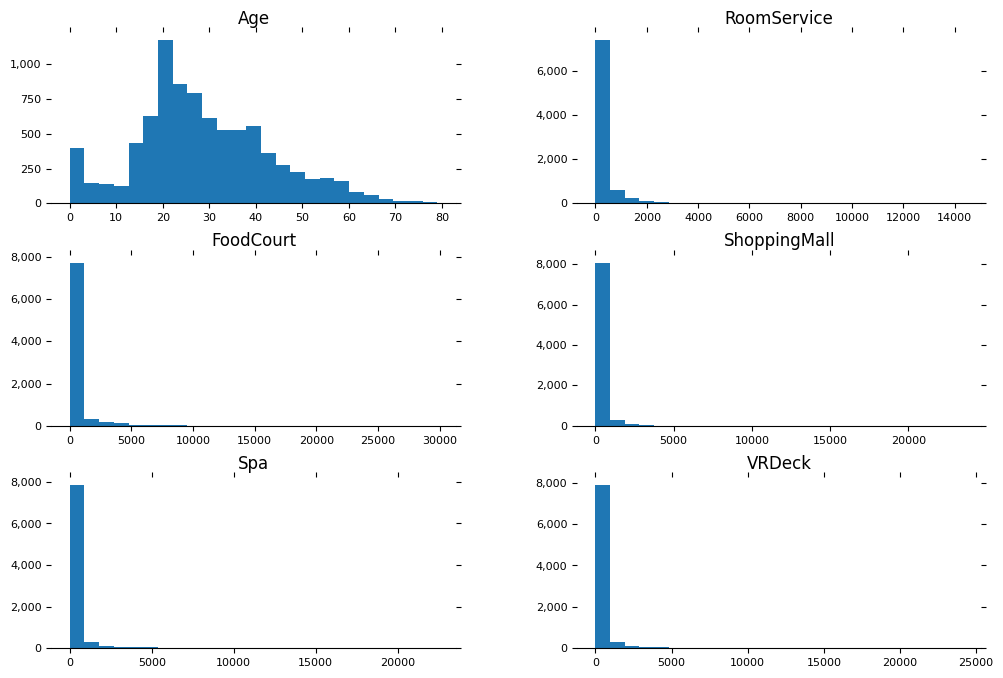

In [5]:
# Plot histograms for all features with customized appearance
ax = train.hist(bins=25, grid=False, figsize=(12, 8), xlabelsize=8, ylabelsize=8)
for i, x in enumerate(ax.flatten()):
    x.spines["right"].set_visible(False)
    x.spines["top"].set_visible(False)
    x.spines["left"].set_visible(False)
    x.tick_params(
        axis="both",
        which="both",
        bottom="off",
        top="off",
        labelbottom="on",
        left="off",
        right="off",
        labelleft="on",
    )
    vals = x.get_yticks()
    x.set_yticklabels(["{:,.0f}".format(v) for v in vals])

# Show the plot
plt.show()

## Data Preprocessing

### Unique Count

In [6]:
# creating a unique count table
col_name = []
col_count = []
for i in range(1, len(train.columns)):
    col_name.append(train.columns[i])
    col_count.append(train[train.columns[i]].nunique())

unique_count = pd.DataFrame(data={"Name": col_name, "Count": col_count})
unique_count.sort_values(by=unique_count.columns[1])

,Name,Count
1,CryoSleep,2
5,VIP,2
12,Transported,2
0,HomePlanet,3
3,Destination,3
4,Age,80
8,ShoppingMall,1115
6,RoomService,1273
10,VRDeck,1306
9,Spa,1327


The above table shows that the features: 'CryoSleep', 'Vip', 'Transported', 'HomePlanet' and Destination have a small number of unique values with some being binary columns. We can perform encoding on these columns.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
# inspect NA vals
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Loads of null values. Need to sort this issue out before moving on to the next step.

In [9]:
# NOTE: this is going to be very controversial, for the time being, removing the null values.
# train_cleaned = train.dropna(how="any")

In [10]:
train_cleaned = train.copy()

In [11]:
train_cleaned["Cabin"].isnull().sum()

199

In [13]:
# feature engineering
# split the Cabin column into deck, num, side

train_cleaned[["deck", "num", "side"]] = train_cleaned["Cabin"].str.split(
    "/", expand=True
)

# train_cleaned["num"] = train_cleaned["num"].astype(int)

/var/folders/cz/sb2kbc4925qcf91d0v0pj8ch0000gn/T/ipykernel_987/1492105587.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(["{:,.0f}".format(v) for v in vals])


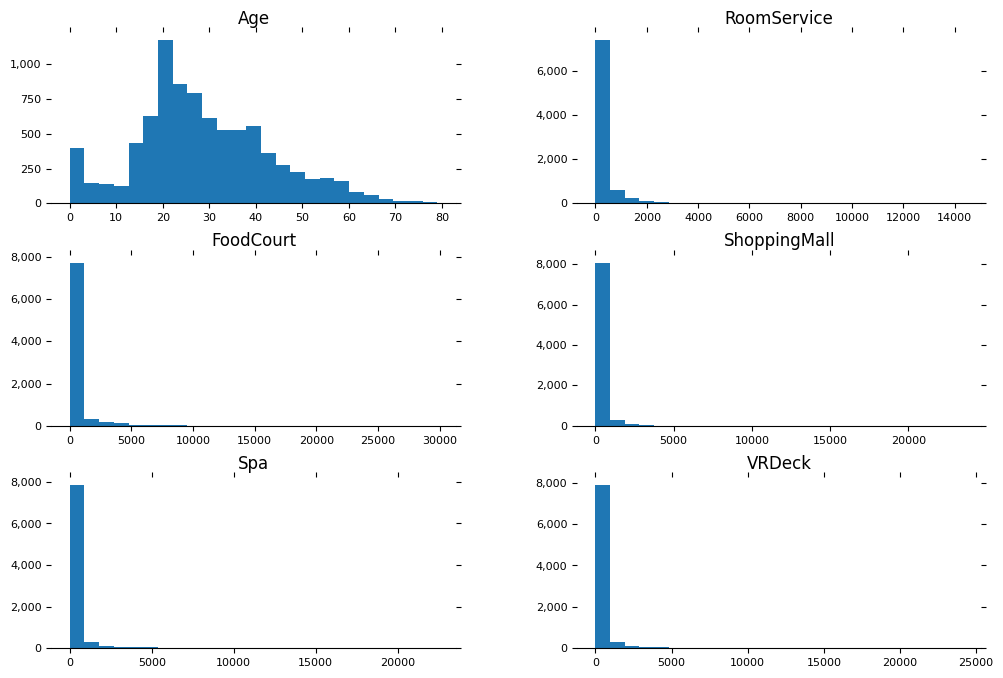

In [16]:
# Plot histograms for all features with customized appearance
ax = train_cleaned.hist(
    bins=25, grid=False, figsize=(12, 8), xlabelsize=8, ylabelsize=8
)
for i, x in enumerate(ax.flatten()):
    x.spines["right"].set_visible(False)
    x.spines["top"].set_visible(False)
    x.spines["left"].set_visible(False)
    x.tick_params(
        axis="both",
        which="both",
        bottom="off",
        top="off",
        labelbottom="on",
        left="off",
        right="off",
        labelleft="on",
    )
    vals = x.get_yticks()
    x.set_yticklabels(["{:,.0f}".format(v) for v in vals])

# Show the plot
plt.show()

/var/folders/cz/sb2kbc4925qcf91d0v0pj8ch0000gn/T/ipykernel_987/2939452982.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(["{:,.0f}".format(v) for v in vals])


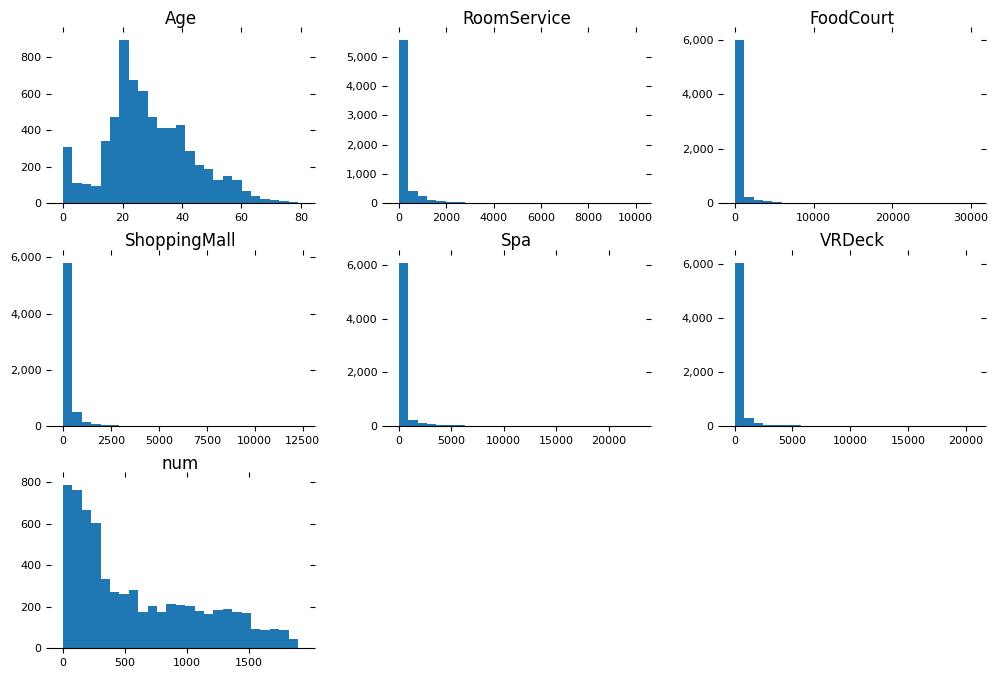

In [25]:
# Drop the NaN values from the 'num' column
train_exp = train_cleaned.copy()

train_exp = train_exp.dropna()
train_exp["num"] = train_exp["num"].astype("int")

# Plot the resulting series
# train_exp.plot()

# Show the plot
ax = train_exp.hist(bins=25, grid=False, figsize=(12, 8), xlabelsize=8, ylabelsize=8)
for i, x in enumerate(ax.flatten()):
    x.spines["right"].set_visible(False)
    x.spines["top"].set_visible(False)
    x.spines["left"].set_visible(False)
    x.tick_params(
        axis="both",
        which="both",
        bottom="off",
        top="off",
        labelbottom="on",
        left="off",
        right="off",
        labelleft="on",
    )
    vals = x.get_yticks()
    x.set_yticklabels(["{:,.0f}".format(v) for v in vals])

# Show the plot
plt.show()

In [27]:
train_cleaned["side"].isnull().sum()

199

### Encoding of categorical values

In [ ]:
# encoding
train_cleaned["HomePlanet"].unique()

array(['Europa', 'Earth', 'Mars'], dtype=object)

In [ ]:
df_temp = pd.get_dummies(
    train_cleaned, columns=["Destination", "HomePlanet", "side", "deck"], dtype="int"
)

df_temp["CryoSleep"] = df_temp["CryoSleep"].replace({True: 1, False: 0})
df_temp["VIP"] = df_temp["VIP"].replace({True: 1, False: 0})

In [ ]:
# drop useless columns like id, name and cabin
df_temp = df_temp.drop(columns=["Cabin", "Name", "PassengerId"])

In [ ]:
# split the train data into x_train and y_train
X_train, y_train = df_temp.drop(columns=["Transported"]), df_temp["Transported"]
y_train = y_train.replace({True: 1, False: 0})

In [ ]:
df_temp.isnull().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
num                          0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
side_P                       0
side_S                       0
deck_A                       0
deck_B                       0
deck_C                       0
deck_D                       0
deck_E                       0
deck_F                       0
deck_G                       0
deck_T                       0
dtype: int64

In [ ]:
# Create an XGBoost classifier model
xgb_model = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
# preds = bst.predict(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Hyperparam optimization
Using GridSearchCV and RandomSearchCV to find the best hyperparameters

### GridSearchCV

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.5, 0.7, 1],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring="roc_auc")

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search_xgb.best_params_)
print("Best score: ", grid_search_xgb.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.001, 'max_depth': 7, 'subsample': 0.5}
Best score:  0.863445503586153


### RandomSearchCV

In [ ]:
param_dist = {
    "max_depth": stats.randint(3, 10),
    "learning_rate": stats.uniform(0.01, 0.1),
    "subsample": stats.uniform(0.5, 0.5),
    "n_estimators": stats.randint(50, 200),
}

# Create the XGBoost model object
xgb_model = XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring="accuracy"
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.07876785851888339, 'max_depth': 3, 'n_estimators': 83, 'subsample': 0.8416109300336089}
Best score:  0.7959482627313238


In [ ]:
# check score between random search and gridsearch
opt_search_param = (
    random_search.best_params
    if random_search.best_score_ > grid_search_xgb.best_score_
    else grid_search_xgb.best_params_
)

In [ ]:
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X_train, y_train)
feature_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)
feature_scores = pd.concat([df_columns, feature_scores], axis=1)
feature_scores.columns = ["Specs", "Score"]
print(feature_scores.nlargest(10, "Score"))

yessir = feature_scores.nlargest(10, "Score")

                Specs         Score
6                 Spa  1.334254e+06
7              VRDeck  1.194503e+06
3         RoomService  7.535346e+05
4           FoodCourt  1.176468e+05
8                 num  6.355811e+03
5        ShoppingMall  1.655653e+03
0           CryoSleep  9.154355e+02
1                 Age  3.290525e+02
13  HomePlanet_Europa  1.634071e+02
18             deck_B  1.279311e+02


In [ ]:
# reduce the number of features down to the 10 best ones
X_train_best = X_train.copy()
opt_cols = yessir["Specs"].tolist()

X_train_best = X_train_best[opt_cols]

In [ ]:
xgb_model = XGBClassifier(**opt_search_param)

# Fit the model
xgb_model.fit(X_train_best, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Opening test dataset

In [ ]:
test = pd.read_csv("data/Test.csv")

In [ ]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Preprocessing Pipeline 
Here, based on the above steps, we will be creating a preprocessing pipeline along with a few modifications to the null values handling steps as just dropping those rows results in a loss of over 2000 rows which could potentiallly affect the ML model's ability to correctly predict

In [ ]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
# remove unnecessary columns
class FeatureSelection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # handle HomePlanet null values
        X = X.drop(columns=["Cabin", "Name", "PassengerId"])

        return X

In [ ]:
class NullHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # handle HomePlanet null values
        modeVal = X["HomePlanet"].value_counts().idxmax()
        X["HomePlanet"] = X["HomePlanet"].fillna(modeVal)
        # CryoSleep
        modeVal_cs = X["CryoSleep"].value_counts().idxmax()
        X["CryoSleep"] = X["CryoSleep"].fillna(modeVal_cs)
        # Destination
        modeVal_dest = X["Destination"].value_counts().idxmax()
        X["Destination"] = X["Destination"].fillna(modeVal_dest)
        # Age
        median = X["Age"].median()
        X["Age"] = X["Age"].fillna(median)

        modeVal_vip = X["VIP"].value_counts().idxmax()
        X["VIP"] = X["VIP"].fillna(modeVal_vip)

        median_rs = X["RoomService"].median()
        X["RoomService"] = X["RoomService"].fillna(median_rs)

        X["FoodCourt"] = X["FoodCourt"].fillna(X["FoodCourt"].median())
        X["ShoppingMall"] = X["ShoppingMall"].fillna(X["ShoppingMall"].median())
        X["Spa"] = X["Spa"].fillna(X["Spa"].median())
        X["VRDeck"] = X["VRDeck"].fillna(X["VRDeck"].median())

        return X

In [ ]:
class EncodeCatVar(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.get_dummies(X, columns=["Destination", "HomePlanet"], dtype="int")

        X["CryoSleep"] = X["CryoSleep"].replace({True: 1, False: 0})
        X["VIP"] = X["VIP"].replace({True: 1, False: 0})

        # select the optimal params
        X_best = X.copy()
        X_best = X[opt_cols]

        return X_best


class DatasetSplit(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # only run dataset split on training set not on test
        X_train, y_train = X.drop(columns=["Transported"]), df_temp["Transported"]
        y_train = y_train.replace({True: 1, False: 0})

        return X_train, y_train

In [ ]:
pipe = Pipeline(
    [
        ("feature_selection", FeatureSelection()),
        ("imputer", NullHandler()),
        ("encoder", EncodeCatVar()),
    ]
)

## Getting predictions and saving it to a file

In [ ]:
y_pred = xgb_model.predict(pipe.fit_transform(test))

KeyError: "['num', 'deck_B'] not in index"

In [ ]:
pred_df = pd.DataFrame({"PassengerId": test["PassengerId"], "Transported": y_pred})

In [ ]:
pred_df = pred_df.replace({1: True, 0: False})

In [ ]:
pred_df.to_csv("submissions/submission4.csv", index=False)

In [ ]:
joblib.dump(xgb_model, "models/model4.joblib")

['models/model4.joblib']